In [29]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import special

In [30]:
def psi0(x, x0, p0, sigma):
    """Initial wave function.
    Average position x0, average momentum p0, width sigma."""
    return np.exp(-((x - x0) * (x - x0 - 2j * p0 * sigma)) / (2 * sigma)) / (np.pi**0.25 * sigma**0.25)

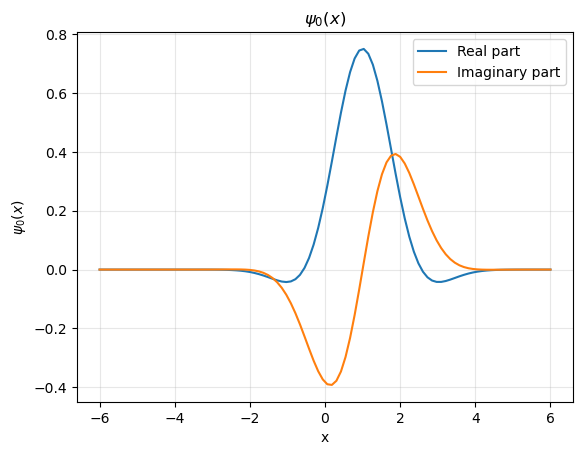

In [31]:
# Example of plot 
plt.plot(np.linspace(-6, 6, 100), np.real(psi0(np.linspace(-6, 6, 100), 1, 1, 1)), label='Real part')
plt.plot(np.linspace(-6, 6, 100), np.imag(psi0(np.linspace(-6, 6, 100), 1, 1, 1)), label='Imaginary part')
plt.title(r'$\psi_0(x)$')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\psi_0(x)$')
plt.grid(alpha=0.3)
plt.show()

In [ ]:

#== Define functions to be used in the Chebyshev expansion ==#

def harmonic_oscillator(x, m=1, omega=1):
    """Harmonic oscillator potential."""
    return 0.5 * m * omega**2 * x**2


def Hamilonian_matrix(N, dx, X, m = 1, omega = 1):
    """Hamiltonian matrix for Chebyshev expansion."""
    H = np.zeros((N, N), dtype=np.complex128)
    for i in range(N):
        for j in [i - 1, i, i + 1]:
            if j < 0 or j >= N:
                continue
            if i == j:
                H[i, j] = 2 / (dx**2) * 1 / (2 * m)  # Kinetic term diagonal
                H[i, j] += harmonic_oscillator(X[i], m, omega)  # Diagonal term with potential
            elif abs(i - j) == 1:
                H[i, j] = -1 / (dx**2) * 1 / (2 * m) #Kinetic term off-diagonal
    return H


def cn(n, lamb, dt):
    """Coefficients of the expansion
     check eq. (8) in https://arxiv.org/pdf/2406.10135"""
    if n == 0:
        return special.jv(0, lamb * dt)
    
    else:
        return 2 * (-1j)**n *  special.jv(n,  lamb * dt)
    

def chebyshev_step(psi, Ham, coeffs):
    """Chebyshev expansion in a time step.
    check eqs. (9) in https://arxiv.org/pdf/2406.10135"""

    fH0 = psi.copy() 
    fH1 = Ham @ psi

    U_est = coeffs[0] * fH0 + coeffs[1] * fH1

    for n in range(2, len(coeffs)): #n >= 2

        fH2 = 2 * Ham @ fH1 - fH0
        
        U_est += coeffs[n] * fH2 #update the estimation of the wave function

        fH0, fH1 = fH1, fH2 #update for next iteration
    
    return U_est


In [ ]:
#== Simulation parameters ==#

dt = 0.05 #time step
t_max = 10 #tmax
T = np.arange(0, t_max, dt) #time domain

L = 10 #length of the domain
N = 128 #number of points in the domain
X = np.linspace(-L/2, L/2, N) #domain
dx = X[1] - X[0] #space res


H = Hamilonian_matrix(N, dx, X) #build hamiltonian matrix

eigenvalues, eigenvectors = np.linalg.eigh(H) #compute eigenvalues

lmax = np.max(eigenvalues) #max eig
lmin = np.min(eigenvalues) #min eig

lamb = lmax - lmin #lambda scaling factor

Hsc = H  /  lamb #rescale the hamitonian

#compute the coefficients (you only need to compute this once for time independent H)
coeffs = [cn(0, lamb, dt)] #first coefficient

while np.abs(coeffs[-1]) > 1e-10: #estabilish a threshold for the coefficients
    coeffs.append(cn(len(coeffs), lamb, dt)) 

print("N coeffs = ", len(coeffs))

#note the large the time step, the more coefficients you need to compute

N coeffs =  39


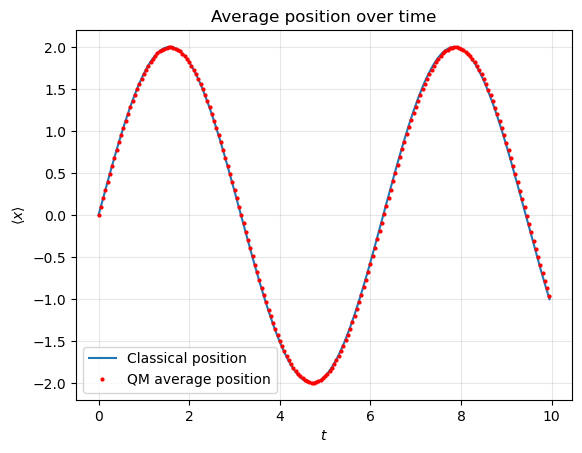

In [34]:

#Initial swave function 
psi = psi0(X, 0, 2, 1)

#Array to store the average position over time
#This is the expectation value of position <x> = ∫ x |ψ(x,t)|^2 dx
average_pos = np.zeros(len(T))
average_pos[0] = np.sum(X * np.abs(psi)**2) * dx

for i_t in range(1, len(T)): #evolve over time

    psi = chebyshev_step(psi, Hsc , coeffs) #compute new psi
    average_pos[i_t] = np.sum(X * np.abs(psi)**2) * dx #compute new <x>s

#plots
plt.plot(T, 2 * np.sin(T), label='Classical position')
plt.plot(T, average_pos, 'o', color = "red", markersize = 2, label='QM average position')
plt.title('Average position over time')
plt.xlabel('$t$')
plt.ylabel(r'$\langle x \rangle$')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
